# Analysis of the Young People Survey Dataset

The goal is to explore and analyse the data set 'Young people survey' downloaded from: https://www.kaggle.com/miroslavsabo/young-people-survey

The data contains survey responses from Slovakians between the ages of 15 - 30 and the questions are based around these areas:
Music preferences, 
Movie preferences,
Hobbies & interests,
Phobias,
Health habits,
Personality traits, views on life, & opinions,
Spending habits,
Demographics

The aim is to see how survey responses can be used to make general inferences from the responses of the survey

Written by: Jaimin Patel

1. Exploration of data including analysis height and weight data 
2. Correlation between musical genres
3. Linear regression to predict age
4. Binary logistic regression to predict gender
5. Support vector machine to compare prediction between logistic regression
6. Categorical logisitic regression to predict  - anything

In [427]:
# Kaggle survey data science analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
import scipy
import scipy.stats as stats
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [428]:
from IPython.display import display

Function Definitions

In [429]:
# Function to return a dataframe of one hot encoded values
def one_hot_encode(df,cat_vars = None, num_vars = None):
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df.num_vars.apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

In [430]:
# Look for dataframe value
def get_target(df, target):
    return df[target]

In [431]:
# Train model using cross_validation
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(df, feature_df, target_df, n_jobs = num_procs, scoring = 'neg_mean_square_error')
    mean_mse[model] = 1.0 - np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

In [432]:
# Print statistics for the trained machine learning model
def summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [433]:
# Plot a ROC curve
def plot_roc(x_test, y_test, grsearch, alg_name , ax = None):
    logit_roc_auc = roc_auc_score(y_test, grsearch.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, grsearch.predict_proba(x_test)[:,1])
    ax = ax or plt.gca()
    ax.plot([0, 1], [0, 1],'r--')
    ax.plot(fpr, tpr)

In [434]:
# Polynomial Regression for R Squared calculation
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # R-squared
    p = np.poly1d(coeffs)
    # Fit values, and mean
    yhat = p(x)                      
    ybar = np.sum(y)/len(y)          
    ssreg = np.sum((yhat-ybar)**2)   
    sstot = np.sum((y - ybar)**2)    
    results['determination'] = ssreg / sstot

    return results

In [435]:
# Plots a correlation plot for two variables
def plot_corr(var_x, var_y, x_name, y_name, ax):
    ax.plot(var_x,var_y,'x')   
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    z = np.polyfit(var_x, var_y, 1)
    p = np.poly1d(z)
    ax.plot(var_x,p(var_x),"r--")

In [436]:
# Plots the average correlation value in two variables
def plot_corr_avg(var_x, var_y, x_name, y_name, plot = None):
    
    min_val = int(var_x.min())
    max_val = int(var_x.max())
    total = np.zeros(max_val-min_val+1)
    num_entries = np.zeros(max_val-min_val+1)
    
    # Get total for the range of values
    for i in range(len(var_x)):
        total[int(var_x[i])-min_val] = total[int(var_x[i])-min_val] + var_y[i]
    for i in range(len(total)):
        num_entries[i] = sum(var_x == min_val+i)
    average = total/num_entries              
    if plot:
        plot.bar(list(range(min_val,max_val+1)),average) 
    else:
        plt.bar(list(range(min_val,max_val+1)),average)
    

In [437]:
# Binary classification implementation, returns the score
def Binary_Classification_GridsearchCV(algorithm, x_train, x_test, y_train, y_test):
    
    # Using KFold cross validation with gridserachcv
    Kfolds = KFold(n_splits = 10)
    parameter_grid = {'C':[.001, 0.01, .03, .1, 0.3, 1, 3, 10]}
    grsearch = GridSearchCV(algorithm, param_grid=parameter_grid, cv=Kfolds, scoring='f1')
    grsearch.fit(x_train, y_train)

    print(grsearch.best_params_)
    y_pred = grsearch.predict(x_test)
    
    return y_pred

In [499]:
# Multiclass Logistic Regression
def Multiclass_Logistic_Regression(y_variable):
    
    ml_inputs = clean.dropna()
    ml_y = ml_inputs[y_variable]

    ml_inputs.drop(columns=y_variable, inplace=True)
    ml_x = ml_inputs

    # Initially using a split of 80-20% training-test data try with (clean)
    x_train, x_test, y_train, y_test = train_test_split(ml_x, ml_y, test_size=0.2)

    # One hot encoder used
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(x_train)
    x_train = encoder.transform(x_train)
    x_test = encoder.transform(x_test)

    logistic_regression_multi = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    logistic_regression_multi.fit(x_train,y_train)

    y_pred_multi = logistic_regression_multi.predict(x_test)
    print("Logistic regression accuracy :", logistic_regression_multi.score(x_test, y_test))
    return y_pred_multi, y_test

# Exploratory Data Analysis for raw survey data

An exploration of the data contained within the survey. From this, we hope to gain an understanding of the survey and respondents. The intention is to see what analysis can be carried out with the data.

In [439]:
# Read data in from csv
data = pd.read_csv(r'/Users/jaimin/Documents/Kaggle/Kaggle-young-people-survey/young-people-survey/responses.csv')

In [440]:
print(data.shape)
data.head(5)

(1010, 150)


,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


There are 1010 responses and 150 questions

In [441]:
# Find the number of missing values
print(data.isna().sum().head(10))
print('Total number of missing values ' + str(data.isna().sum().sum()))

Music                       3
Slow songs or fast songs    2
Dance                       4
Folk                        5
Country                     5
Classical music             7
Musical                     2
Pop                         3
Rock                        6
Metal or Hardrock           3
dtype: int64
Total number of missing values 608


Clean data by imputing missing data getting a median result for each category median used as each response is an integer value as there are 1010 responses imputing data rather than dropping is the preferred method

In [442]:
clean = data.fillna(data.median())

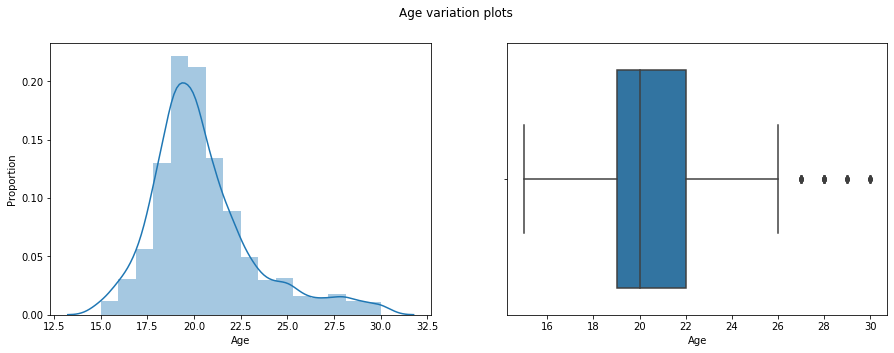

In [443]:
# Plot to show distribution of age range
# plt.figure(figsize = (15 ,5))

fig, ax = plt.subplots(1,2, figsize = (15,5))
fig.suptitle("Age variation plots")
ax[0] = plt.subplot(1,2,1)
sns.distplot(clean.Age, bins=16)
plt.ylabel("Proportion")

plt.subplot(1,2,2)
sns.boxplot(clean.Age)
plt.show()

The age variation plots indicate an near normal distribution of ages around approximately 19 years old. The lowest age is 15 and the highest is 30.

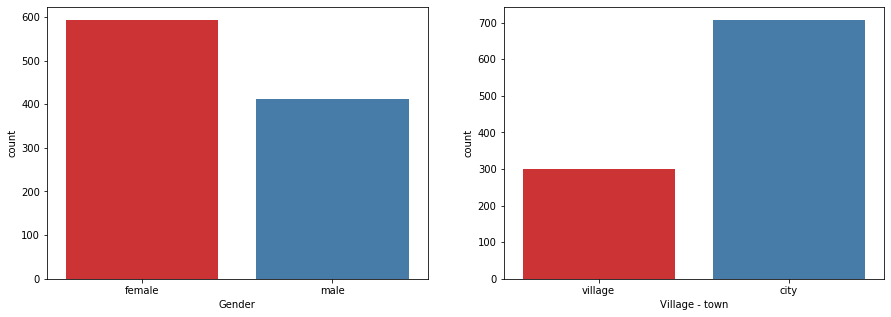

In [444]:
# Looking at the proportion of male to female respondents and whether respondents live in a village or city
plt.figure(figsize = (15,5))
plt.suptitle("")
plt.subplot(1,2,1)
sns.countplot(clean['Gender'], palette = "Set1")
plt.subplot(1,2,2)
sns.countplot(clean['Village - town'], palette = "Set1")

plt.show()

More than twice as many respondents live in cities rather than villages and the survey was taken by more females than males

# Correlation of height and weight

An investigation of the height and weight of respondents

In [445]:
# Looking at weight and height of respondents
weight = clean['Weight'].mean()
height = clean['Height'].mean()

print('Mean Weight = %.2f kg' % weight)
print('Mean Height = %.2f cm' % height)

Mean Weight = 66.36 kg
Mean Height = 173.50 cm


Plotting height against weight fitting a linear trendline to the correlation. Correlation coefficient (R-value) is also calculated

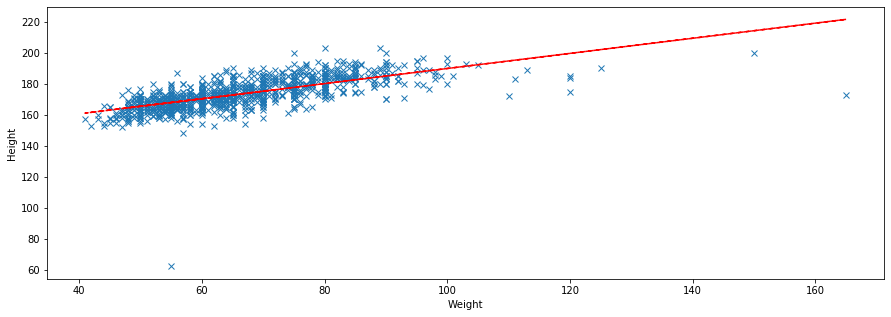


R-Val (correlation coefficient) = 0.675


In [446]:
height_df = clean.Height
weight_df = clean.Weight
fig, ax = plt.subplots(figsize = (15,5))
plot_corr(weight_df, height_df, 'Weight','Height', ax)
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(weight_df,height_df)
print('\nR-Val (correlation coefficient) = %.3f' %r_value)

The data looks to be correlated resonably well with a correlation coefficient of 0.675

We see some outlier values such as a Height ≈ 65cm and Weight ≈ 55 kilograms (≈120 lbs)

These outliers should be dropped from the data. To do this we split the data into numeric and categorical data and use Z-score to drop data furthest from the mean value.

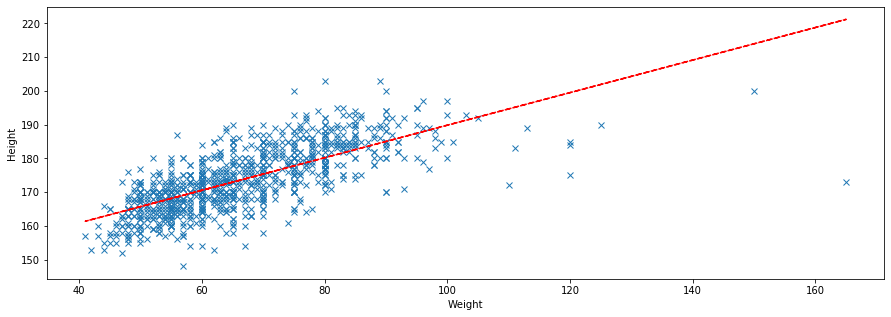


R-Val (correlation coefficient) = 0.712


In [447]:
# Data categorised either by numeric or categorical values
features_numeric = [col for col in data.columns if data[col].dtype != 'object']
features_categories = [col for col in data.columns if data[col].dtype == 'object']

# Calculating Z-score and choosing a Z score of 8(number of std deviations from mean) to drop the incorrect data
z = np.abs(stats.zscore(clean[features_numeric]))
height_weight_df = clean[(z < 8).all(axis=1)]
fig, ax = plt.subplots(figsize = (15,5))
plot_corr(height_weight_df.Weight, height_weight_df.Height, 'Weight','Height', ax)
plt.show()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(height_weight_df.Weight, height_weight_df.Height)
print('\nR-Val (correlation coefficient) = %.3f' %r_value)

Once the outliers have been dropped, we obtain a clearer plot and an improved correlation coefficient = 0.712

An intereing investigation is seeing how this data is grouped within genders so we divide the height and weight into gender try the same correlation plot within each group

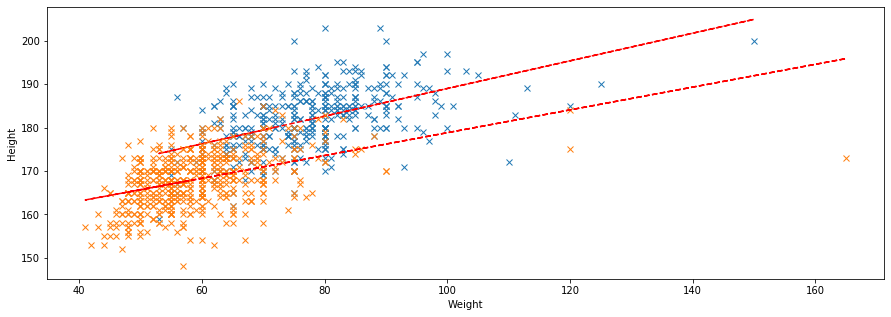


Male R-Value = 0.518
Female R-Value = 0.429


In [448]:
male_df = height_weight_df[height_weight_df["Gender"] == "male"]
female_df = height_weight_df[height_weight_df["Gender"] == "female"]

fig, ax = plt.subplots(figsize = (15,5))
plot_corr(male_df.Weight, male_df.Height, 'Weight','Height', ax)
slope, intercept, m_r_value, p_value, std_err = scipy.stats.linregress(male_df.Weight, male_df.Height)
plot_corr(female_df.Weight, female_df.Height, 'Weight','Height', ax)
slope, intercept, f_r_value, p_value, std_err = scipy.stats.linregress(female_df.Weight, female_df.Height)
plt.show()
print('\nMale R-Value = %.3f' %m_r_value)
print('Female R-Value = %.3f' %f_r_value)

It is interesting that the correlation between height and weight is lower for both males and females individually. 

This can be explained by the mean female height and weight value which is lower than that of the male data. The interaction between the two data clusters leads to a correlation value which is skewed a positive correlation between male and female data.

# Investigating correlation between musical genres
Investigating the musical preferences and any correlations between music genres in a correlation heatmap

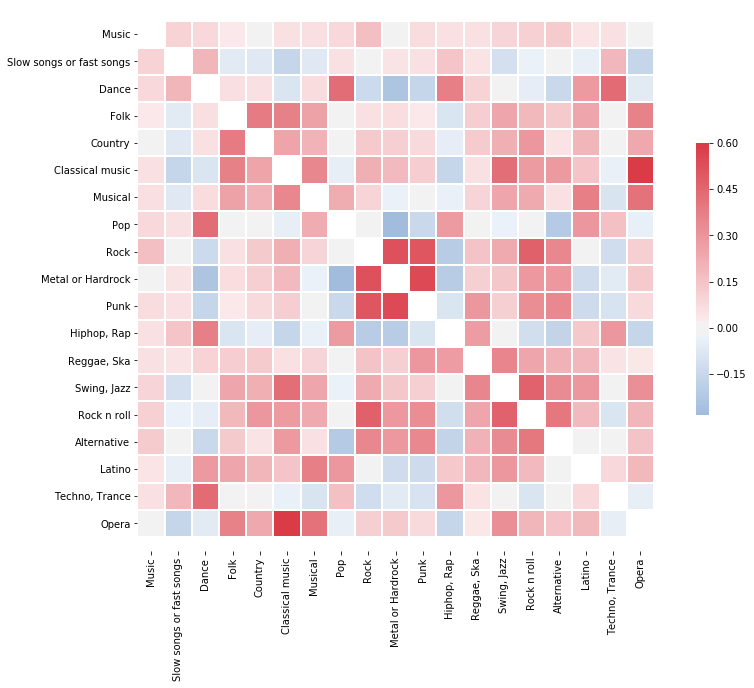

In [449]:
# Select musical categories to perform analysis on
music = ['Music','Slow songs or fast songs','Dance','Folk','Country','Classical music','Musical','Pop','Rock','Metal or Hardrock','Punk','Hiphop, Rap','Reggae, Ska','Swing, Jazz','Rock n roll','Alternative','Latino','Techno, Trance','Opera']

corr = clean[music].corr()
mask = np.zeros_like(corr, dtype=np.bool)
np.fill_diagonal(mask, True)
f, ax = plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.6,center=0,square=True,linewidths=1,cbar_kws={"shrink": .5})
ax.set_ylim(len(music)+0.5, -0.5)
plt.show()

Looking at the correlation heatmap, positive correlation between genres is far stronger than negative correlation. It is interesting to see 'Metal or Hardrock' has a more polar view of music with respondents likely to correlate strongly or negatively with other genres seen from the darker red and blue shades. 'Rock', 'Metal or Hardrock' and 'Punk' are very strongly correlated with each other as is 'Classical Music' and 'Opera'. On the other hand, 'Metal or Hardrock' and 'Pop' are negatively correlated.

Another interesting category to analyse is the 'Hiphop, Rap' group which is more likely to correlate negatively with other genres indicated by the amount of blue in this row/column compared with other genres. The listeners of 'Hiphop and Rap' are less likely to enjoy to other genres of music.

Digging deeper into these positively and negatively correlated values on the heatmap. Two musical genres are plotted against one another. For all respondents who voted from 1-5 of the first music genre, an average value of their score for the second genre is plotted on the y axis.

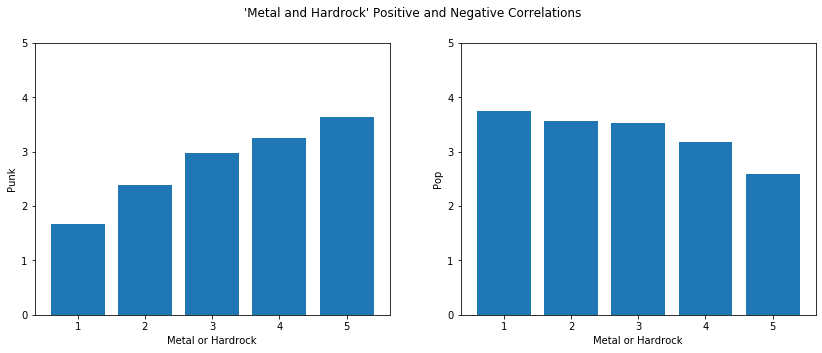

In [450]:
var_x = 'Metal or Hardrock'
var_y = 'Punk'

fig, ax = plt.subplots(1,2, figsize = (14,5))
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[0])
ax[0].set_xlabel(var_x)
ax[0].set_ylabel(var_y)

# Changing the y variable to pop
var_y = 'Pop'
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[1])
ax[1].set_xlabel(var_x)
ax[1].set_ylabel(var_y)

plt.setp(ax, ylim = (0,5))
plt.suptitle("'Metal and Hardrock' Positive and Negative Correlations")
plt.show()

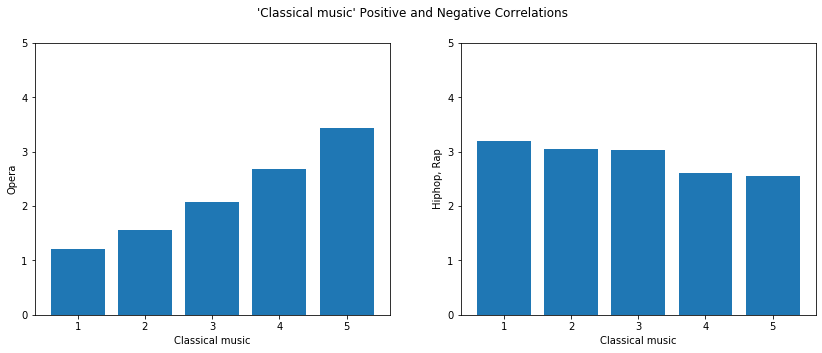

In [451]:
var_x = 'Classical music' 
var_y = 'Opera'

fig, ax = plt.subplots(1,2, figsize = (14,5))
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[0])
ax[0].set_xlabel(var_x)
ax[0].set_ylabel(var_y)

# Changing the x variable to Hiphop, Rap
var_y = 'Hiphop, Rap'
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[1])
ax[1].set_xlabel(var_x)
ax[1].set_ylabel(var_y)
plt.setp(ax, ylim = (0,5))
plt.suptitle("'Classical music' Positive and Negative Correlations")
plt.show()

The strongly positive and negative correlations between music genres such as Punk and Metal or Hardrock and Classical Music and Hiphop, Rap can be seen more clearly here. For each category of the x axis, the y is the average for this x axis group.

Investigating the opinions of survey respondents against age, elections and changing the past as two likely factors that age may change

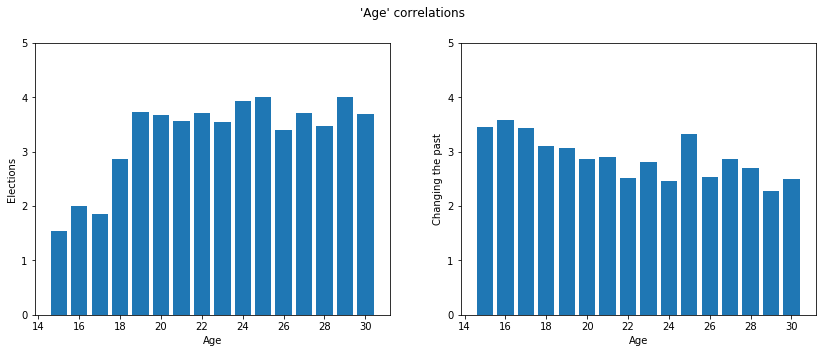

In [452]:
var_x = 'Age'
var_y = 'Elections'

fig, ax = plt.subplots(1,2, figsize = (14,5))
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[0])
ax[0].set_xlabel(var_x)
ax[0].set_ylabel(var_y)

# Changing the y variable
var_y = 'Changing the past'
plot_corr_avg(clean[var_x], clean[var_y], var_x, var_y, ax[1])
ax[1].set_xlabel(var_x)
ax[1].set_ylabel(var_y)

plt.setp(ax, ylim = (0,5))
plt.suptitle("'Age' correlations")

plt.show()

From the plots we see some interesting results. Respondents from ages 15-18 have a very little interest in elections. There is a large step in interest from 17 - 19 and beyond 19, the interest in voting in elections stays approximately constant. This corresponds nicely with the legal voting age of Slovenia which is 18.

Generally older respondents, want to change the past less. This could be due to any number of reasons, perhaps simply by living longer, people become more content with their past. Maybe from a teenager to a young adult, there is more uncertainty about their future so they think decisions they made will have greater consequences later on in life.


# Linear Regression to predict age

Calculating linear regression on numerical data to predict age. Divide dataset into male and female data, include only numeric features and drop the age variable from the data we perform calculations on.

In [453]:
# Trying Linear Regression to Predict age categorised by gender
male_df = clean[clean["Gender"] == "male"]
female_df = clean[clean["Gender"] == "female"]

male_numeric = male_df[features_numeric]
female_numeric = female_df[features_numeric]

# Store Age in each dataframe and drop it from the main one
male_height = male_numeric['Age']
female_height = female_numeric['Age']
male_numeric.drop("Age", axis=1, inplace = True)
female_numeric.drop("Age", axis=1, inplace = True)

# Do a test train split
X_train_m , X_test_m, y_train_m, y_test_m = train_test_split(male_numeric, male_height, test_size=0.2, random_state=0)
X_train_f , X_test_f, y_train_f, y_test_f = train_test_split(female_numeric, female_height, test_size=0.2, random_state=0)

regressor_m = LinearRegression()
regressor_f = LinearRegression()
regressor_m.fit(X_train_m, y_train_m)
regressor_f.fit(X_train_f, y_train_f)
y_pred_m = regressor_m.predict(X_test_m)
y_pred_f = regressor_f.predict(X_test_f)

df_m = pd.DataFrame({'Actual': y_test_m, 'Predicted': y_pred_m})
print('Male Age Actual and Predicted')
print(df_m.head(5))
print("\nFemale Age Actual and Predicted")
df_f = pd.DataFrame({'Actual': y_test_f, 'Predicted': y_pred_f})
print(df_f.head(5))
print('\nMale Root Mean Squared Error: %.3f years' %np.sqrt(metrics.mean_squared_error(y_test_m, y_pred_m)))
print('\nFemale Root Mean Squared Error: %.3f years' %np.sqrt(metrics.mean_squared_error(y_test_f, y_pred_f)))

Male Age Actual and Predicted
     Actual  Predicted
762    24.0  22.993471
181    23.0  22.373645
835    19.0  20.498324
872    20.0  20.128763
768    26.0  25.856575

Female Age Actual and Predicted
     Actual  Predicted
391    24.0  20.358650
232    19.0  17.892050
973    20.0  20.764532
145    19.0  23.848306
276    21.0  16.078404

Male Root Mean Squared Error: 3.198 years

Female Root Mean Squared Error: 2.634 years


Age prediction using linear regression on all numerical data (dropping age itself). For male respondents, the root mean square error is 3.20 years and for females it is 2.63. It is interesting to see that in the variety of survey responses and categories, age can be accurately predicted. An example of influencing factors may be height, weight and elections as changed with respect to age.

# EDA Summary

Looking at the EDA, the respondents are a range of ages from 15 to 30, most are around 20 years old who are city dwellers and female. They have a range of musical preferences showing trends in similar genres.

# Logistic regression and SVM to classify gender

For machine learning we standardise variables and ensure regularisation to dataset

In [465]:
# Looking at the numerical data
clean.describe(include = np.number)

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Shopping centres,Branded clothing,Entertainment spending,Spending on looks,Spending on gadgets,Spending on healthy eating,Age,Height,Weight,Number of siblings
count,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,...,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.000000,1010.00000
mean,4.732673,3.327723,3.112871,2.287129,2.122772,2.956436,2.762376,3.473267,3.763366,2.360396,...,3.233663,3.050495,3.200990,3.105941,2.870297,3.558416,20.430693,173.503960,66.357426,1.29604
std,0.663222,0.833232,1.168268,1.136271,1.073501,1.248223,1.259639,1.160029,1.181474,1.371093,...,1.321791,1.305028,1.187229,1.203589,1.284970,1.092842,2.819240,9.924916,13.705814,1.01059
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,62.000000,41.000000,0.00000
25%,5.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,19.000000,167.000000,56.000000,1.00000
50%,5.000000,3.000000,3.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,2.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,20.000000,173.000000,64.000000,1.00000
75%,5.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,22.000000,180.000000,75.000000,2.00000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,30.000000,203.000000,165.000000,10.00000


In [466]:
# Looking at the non-numerical data in the dataframe
clean.describe(include = ['O'])

,Smoking,Alcohol,Punctuality,Lying,Internet usage,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
count,1002,1005,1008,1008,1010,1004,1007,1009,1008,1006,1006
unique,4,3,3,4,4,2,2,6,2,2,2
top,tried smoking,social drinker,i am always on time,sometimes,few hours a day,female,right handed,secondary school,no,city,block of flats
freq,430,659,399,549,744,593,906,621,754,707,595


Now we perform analysis to see what we can infer from the survey using machine learning models

From the responses of the survey we predict gender from Binary logistic regression and tune parameters to get the highest accuracy using gridsearch CV.

Then the same analysis is carried out using SVM again with gridsearch CV.

In [467]:
# Prepare data for gender classification
# Assign a variable for binary classification
y_variable = "Gender"

category_map = {y_variable:{'male': 0, 'female': 1}}
ml_inputs = clean.dropna()
ml_y = ml_inputs[y_variable]
ml_inputs.drop(columns=y_variable, inplace = True)
ml_x = ml_inputs[features_numeric]

for key,val in category_map[y_variable].items():
    ml_y.replace(key, val, inplace = True)

In [468]:
# Initially using a split of 80-20% training-test data and implementing feature normalisation
x_train, x_test, y_train, y_test = train_test_split(ml_x, ml_y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [469]:
# Logistic regression for classification
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)
log_y_pred = Binary_Classification_GridsearchCV(logistic_regression, x_train, x_test, y_train, y_test)

{'C': 0.03}


Now implementing SVM to classify gender. This is for a comparison to Logistic regression for accuracy

In [470]:
# Using the support vector machine algorithm for classification
# svc = svm.SVC(kernel = 'linear',probability=True)
svc = svm.SVC(gamma = 'scale', decision_function_shape='ovo',probability=True)
log_y_pred = Binary_Classification_GridsearchCV(svc, x_train, x_test, y_train, y_test)

{'C': 1}


## Results
Showing results of logistic regression and SVM using f1 score and plotting ROC curves

Logistic Regression confusion matrix and classification report
[[26 43]
 [49 78]]
              precision    recall  f1-score   support

           0       0.35      0.38      0.36        69
           1       0.64      0.61      0.63       127

    accuracy                           0.53       196
   macro avg       0.50      0.50      0.50       196
weighted avg       0.54      0.53      0.53       196

SVM confusion matrix and classification report
[[ 77   9]
 [  3 107]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        86
           1       0.92      0.97      0.95       110

    accuracy                           0.94       196
   macro avg       0.94      0.93      0.94       196
weighted avg       0.94      0.94      0.94       196



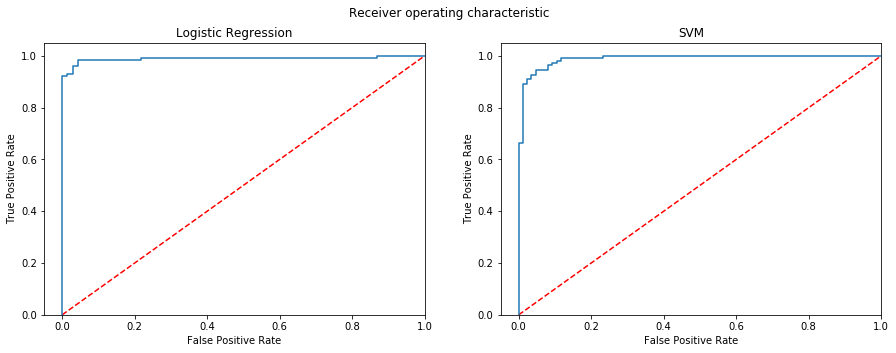

Logistic regression accuracy: 0.6943396226415095
Average precision-recall score: 0.65

SVM accuracy: 0.9469026548672567
Average precision-recall score: 0.91


In [471]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.set_xlim([-0.05, 1.0])
ax2.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax2.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax2.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax2.set_ylabel('True Positive Rate')
fig.suptitle('Receiver operating characteristic')

plt.savefig('Log_ROC')

plot_roc(log_x_test, log_y_test, log_grsearch, 'Logistic Regression', ax1)
plot_roc(svm_x_test, svm_y_test, svm_grsearch, 'SVM', ax2)

ax1.set_title('Comparing ROC curves for Logisitic regression and SVM')
ax1.set_title('Logistic Regression')
ax2.set_title('SVM')

conf_matrix = confusion_matrix(log_y_test, log_y_score)
print("Logistic Regression confusion matrix and classification report")
print(conf_matrix)
print(classification_report(log_y_test, log_y_score))


conf_matrix = confusion_matrix(svm_y_test, svm_y_score)
print("SVM confusion matrix and classification report")
print(conf_matrix)
print(classification_report(svm_y_test, svm_y_score))

plt.show()

print("Logistic regression accuracy:", log_grsearch.score(x_test, log_y_test))
average_precision = average_precision_score(log_y_test, log_y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

print("\nSVM accuracy:", svm_grsearch.score(svm_x_test, svm_y_test))
average_precision = average_precision_score(svm_y_test, svm_y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

We see that both Logistic Regression and SVM are accurate ways to classify gender from the survey responses. The ~96% accurate for logistic regression is comparable to that of SVM both using gridsearchcv sklearn method.

The confusion matrix with f1 scores shows the precision and recall were high at about ~95%

Analysing the ROC curves: They both hug the y-axis and have a flat top, showing that the prediction of gender is accurate from the responses of the survey

# Multiclass Logistic Regression

Using "Internet usage" as the multiclass logistic regression classification variable. This is grouped into categoires: "few hours a day", "most of the day", "less than an hour a day"

In [500]:
# Put in y_variable
y_variable = "Internet usage"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.5663265306122449


In [482]:
y_variable = "Smoking"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.34183673469387754


In [501]:
y_variable = "Village - town"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.7602040816326531


In [486]:
y_variable = "Alcohol"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.5918367346938775


In [490]:
y_variable = "Punctuality"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.41836734693877553


In [492]:
y_variable = "Lying"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.47959183673469385


In [493]:
y_variable = "Only child"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.7959183673469388


In [509]:
y_variable = "House - block of flats"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.7193877551020408


In [502]:
y_variable = "Gender"
y_score, y_test = Multiclass_Logistic_Regression(y_variable)

Logistic regression accuracy : 0.9030612244897959


In [510]:
y_score_df = pd.Series(y_score)
y_1 = y_test.value_counts().to_frame()
y_score_all
y_score_all = y_score_df.value_counts().to_frame()
# y_score_all = y_score_df.value_counts()
print(y_1)
print(y_score_all)

                House - block of flats
block of flats                     129
house/bungalow                      67
                  0
block of flats  120
house/bungalow   76


In [496]:
y_score_df = pd.Series(y_score)
y_1 = y_test.value_counts().to_frame()
y_score_all = y_score_df.value_counts()

if y_1.index.contains('no time at all'):
    to_append = pd.Series([0], index = ['no time at all'])
    y_score_all = y_score_df.value_counts().append(to_append)

print(y_1)
print(y_score_all)

                         Internet usage
few hours a day                     150
less than an hour a day              26
most of the day                      19
no time at all                        1
female            118
male               78
no time at all      0
dtype: int64


In [475]:
# # fig, axes = plt.subplots(1, 2, figsize = (10,10)) https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# fig, ax = plt.subplots(figsize = (15,5))

# labels = ['no time at all', 'less than an hour a day', 'few hours a day', 'most of the day']
# x = np.arange(len(labels)-1)
# width = 0.35

# # y_score_vals = y_score_df.value_counts().to_frame()
# y_score_vals = y_score_all.to_frame()
# y_score_vals.columns = ["Internet usage"]
# y_test_vals = y_test.value_counts().to_frame()

# # prediction = ax.bar(y_score_vals.index, y_score_vals["Internet usage"], width, label = "Prediction")
# prediction = ax.bar(x - 0.5 *width, y_score_vals["Internet usage"], width, label = "Prediction", align = "center")
# test = ax.bar(x + 0.5* width, y_test_vals["Internet usage"], width, label = "Test", align = "center")

# ax.set_xticks(x)
# ax.set_xticklabels(labels[:3])
# print(y_score_vals)
# print(y_test_vals)

# plt.show()

Applying logistic regression for multiclass classification for how much a person uses internet per day reasonably accurate, 60-70% of the time predicting correctly

In summary, the data has been explored and predictions have been made about the respondents of the survey.